# 0. Attaching libraries

In [1]:
import os
import sqlite3
import pandas as pd
import sys
#from ydata_profiling import ProfileReport # for profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("whitegrid")       # optional aesthetics
%matplotlib inline 

In [2]:
# Pre-processing & modelling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Cluster diagnostics
from sklearn.metrics import silhouette_score

In [3]:
from dateutil.relativedelta import relativedelta
import builtins

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

import matplotlib.patches as mpatches


In [5]:
from sklearn.decomposition import PCA

# 1. Reading the core Dataset from the golden source

In [8]:
csv_file  = "https://raw.githubusercontent.com/mithridata-com/NOVAIMS_BDMwDS_PROJECT/refs/heads/main/00%20Data/Dataset.csv?token=GHSAT0AAAAAADEUY5L7N2QTI43CBPMTAV5O2CIUAMQ"

excel_path  = (r"C:\Users\dimet\Documents\GitHub\NOVAIMS_BDMwDS_PROJECT\02 Output\02 TB Conversion Analytics.xlsx")

In [9]:
# ── Load the CSV into a DataFrame ──────────────────────────────────────────
df = pd.read_csv(csv_file, low_memory=False)

In [10]:
# Quick sanity check (optional)
print(df.shape)       # prints (rows, columns)

(9373, 78)


In [11]:
df.columns

Index(['affinity_name', 'status_report', 'offer_number', 'policy_number',
       'zipcode_link', 'zip4', 'birth_date', 'brand', 'date_offer',
       'date_request', 'policy_start_date', 'premium', 'buildyear_car',
       'buildmonth_car', 'wa', 'wa_bep_ca', 'wa_ca', 'updated_on',
       'policy_continuation_date', 'policy_start_date_pol',
       'policy_lastchange_date', 'premium_wa', 'premium_other',
       'zipcode_link_pol', 'zip4_pol', 'place_residence', 'birth_date_pol',
       'gender', 'private_commercial', 'bonus_malus_percent', 'other_cover',
       'premium_other_incl_discount', 'worth_car', 'brand_pol',
       'builddate_car', 'weight_car', 'mileage_car', 'power_car', 'fuel_car',
       'chassis', 'drive', 'turbo', 'transmission', 'zip4_reg', 'PROVINCE',
       'URB', 'INCOME', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
       'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK', 'OWN_HOUSE',
       'AVG_HOUSE', 'RENT_PRICE', 'STAGE_OF_LIFE', 'SINGLE', 'FAM',
       'FAM_W

## NEW COLUMNS

In [12]:
df["customer_id"] = df[["zipcode_link", "zip4", "place_residence","birth_date", "gender"]].astype(str).agg("-".join, axis=1)

In [13]:
df['premium_total'] = df['premium_wa'].fillna(0) + df['premium_other'].fillna(0)

In [14]:
df['premium_discount'] = df['premium_other'].fillna(0) - df['premium_other_incl_discount'].fillna(0)

In [15]:
# 1. Build boolean conditions based on == "Y"
conditions = [
    df['wa'] == 'Y',
    df['wa_bep_ca'] == 'Y',
    df['wa_ca'] == 'Y'
]

# 2. Corresponding labels
choices = ['1. Only liability insurance', '2. Liability + limited casco', '3. Liability + full casco']

# 3. Create the new column, defaulting to NaN if none of the three has "Y"
df['coverage_type'] = np.select(conditions, choices, default="")

In [16]:
# ── 1. External “today” reference ───────────────────────────────────────────
current_date = pd.to_datetime("2019-11-01")    # ← use any value you like
fancy_date = current_date.strftime("%B %d %Y")

In [17]:
# ── 2. Parse birth_date & compute age ───────────────────────────────────────
# 2-a. Ensure birth_date is a datetime column
df["birth_date"] = pd.to_datetime(df["birth_date"], errors="coerce")

# 2-b. Convert to integer years using dateutil.relativedelta for accuracy
df["age"] = df["birth_date"].apply(
    lambda bd: relativedelta(current_date, bd).years if pd.notnull(bd) else pd.NA
)
# ── 1. Ensure age is numeric ────────────────────────────────────────────────
# (errors='coerce' converts any bad strings to NaN so they drop out later)
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# ── 2. Create age bands ─────────────────────────────────────────────────────
age_bins   = [0, 25, 35, 45, 55, 65, 120]               # tweak if needed
age_labels = ["<25", "25–34", "35–44", "45–54", "55–64", "65+"]

In [18]:
df["age_band"] = pd.cut(df["age"],
                           bins=age_bins,
                           labels=age_labels,
                           right=False)

In [19]:
df["urb_norm"] = (
    df["URB"]
      .astype(str)
      .str.strip()
      .str[0]                    # first letter
      .str.upper()
      .replace({"1": "1-VeryHigh", "2": "2-High", "3": "3-Mid-to-High", "4": "4-Mid", "5": "5-Mid-to-Low", "6": "6-Low","7": "7-VeryLow", "0": "Unknown", "N" : "Unknown"})
)

In [20]:
month_map = {
    "January":   "01",
    "February":  "02",
    "March":     "03",
    "April":     "04",
    "May":       "05",
    "June":      "06",
    "July":      "07",
    "August":    "08",
    "September": "09",
    "October":   "10",
    "November":  "11",
    "December":  "12"
}

df["buildmonth_num"] = df["buildmonth_car"].map(month_map)

In [21]:
# 2. Combine year + month + “01” (first of month) into a YYYY-MM-DD string and convert to datetime:
df["build_date"] = pd.to_datetime(
    df["buildyear_car"].astype(str).str[:4] + "-" + 
    df["buildmonth_num"] + "-01"
)

# Now 'build_date' holds a Timestamp for the first day of that month/year.
print(df[["buildyear_car", "buildmonth_car", "build_date"]].head())

   buildyear_car buildmonth_car build_date
0         2016.0           June 2016-06-01
1         2015.0           June 2015-06-01
2         2016.0          April 2016-04-01
3         2009.0           June 2009-06-01
4         2003.0        January 2003-01-01


In [22]:
# Calculate car_age
df['car_age'] = current_date.year - df['build_date'].dt.year - (
    (current_date.month < df['build_date'].dt.month) |
    ((current_date.month == df['build_date'].dt.month) & (current_date.day < df['build_date'].dt.day))
).astype(int)

In [23]:
# 1) Make sure `policy_start_date` is a datetime:
df['policy_start_date'] = pd.to_datetime(
    df['policy_start_date'],
    errors='coerce'
)

In [24]:
# Define age bins and labels
bins = [0, 3, 7, 11, 100]
labels = ['0-3', '4-7', '8-11', '12+']

# Create normalized age categories
df['car_age_norm'] = pd.cut(df['car_age'], bins=bins, labels=labels, include_lowest=True).cat.add_categories('Unknown').fillna("Unknown")


In [25]:
df

,affinity_name,status_report,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,date_offer,date_request,...,premium_total,premium_discount,coverage_type,age,age_band,urb_norm,buildmonth_num,build_date,car_age,car_age_norm
0,Insuro,Requestwithdrawn,1000,10000.0,10000,2132,1985-01-01,HYUNDAI,2018-10-11,2018-10-11,...,0.0,0.0,1. Only liability insurance,34.0,25–34,3-Mid-to-High,06,2016-06-01,3.0,0-3
1,other,Tailoredofferwithdrawn,1001,NaN,10001,6027,1987-04-01,AUDI,2018-10-11,NaN,...,0.0,0.0,,32.0,25–34,7-VeryLow,06,2015-06-01,4.0,4-7
2,other,Incompleterequest,1002,NaN,10002,3824,1972-11-01,VOLKSWAGEN,2018-10-11,NaN,...,0.0,0.0,3. Liability + full casco,47.0,45–54,2-High,04,2016-04-01,3.0,0-3
3,other,Policycreated,1003,10002.0,10003,6921,1983-08-01,MAZDA,2018-10-11,2018-10-11,...,0.0,0.0,2. Liability + limited casco,36.0,35–44,4-Mid,06,2009-06-01,10.0,8-11
4,other,Policycreated,1004,10003.0,10004,8266,1990-04-01,VOLVO,2018-10-12,2018-10-12,...,0.0,0.0,1. Only liability insurance,29.0,25–34,4-Mid,01,2003-01-01,16.0,12+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9368,other,Requestaccepted,9439,11946.0,15568,1161,1960-09-01,VOLKSWAGEN,2020-03-08,2020-03-08,...,0.0,0.0,3. Liability + full casco,59.0,55–64,6-Low,12,2011-12-01,7.0,4-7
9369,other,Waitforapproval,9440,11947.0,15582,5015,1953-04-01,NISSAN,2020-03-08,2020-03-08,...,0.0,0.0,3. Liability + full casco,66.0,65+,2-High,02,2017-02-01,2.0,0-3
9370,Insuro,Tailoredofferrequested,9441,NaN,10332,3078,1976-04-01,TOYOTA,2020-03-08,NaN,...,0.0,0.0,2. Liability + limited casco,43.0,35–44,1-VeryHigh,01,2004-01-01,15.0,12+
9371,T&B,Calculatenewpremium,9442,NaN,12968,1965,1951-07-01,TOYOTA,2020-03-08,NaN,...,0.0,0.0,2. Liability + limited casco,68.0,65+,4-Mid,09,2004-09-01,15.0,12+


In [26]:
# list of cols to convert
num_cols = ['worth_car', 'weight_car', 'mileage_car', 'power_car']

# coerce to numeric, invalid parsing becomes NaN
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# IMPUTATION

In [27]:
num_cols = [
    'worth_car',
    'weight_car',
    'mileage_car',
    'power_car'
]

cat_cols = [
    'chassis',
    'fuel_car',
    'drive',
    'turbo',
    'transmission'
]


In [28]:
# for each numeric column, fill NAs with the mean _within_ its brand
df[num_cols] = (
    df
    .groupby('brand')[num_cols]
    .transform(lambda col:
        col.fillna(col.mean())    # group-mean imputation
    )
)

In [29]:
def fill_with_mode(series):
    # find the most common value
    modes = series.dropna().mode()
    if len(modes) > 0:
        return series.fillna(modes.iloc[0])
    else:
        return series

df[cat_cols] = (
    df
    .groupby('brand')[cat_cols]
    .transform(fill_with_mode)
)

In [30]:
print(df[num_cols + cat_cols].isna().sum())

worth_car       302
weight_car      302
mileage_car     302
power_car       302
chassis         302
fuel_car        302
drive           302
turbo           302
transmission    302
dtype: int64


In [31]:
mode_income = (
    df
    .groupby('zip4')['INCOME']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income')
)

# 2. Merge the mode back into the original DataFrame
df = df.merge(mode_income, left_on='zip4', right_index=True)

# 3. Impute missing INCOME values using the mode for that zip4
df['INCOME_filled'] = df['INCOME'].fillna(df['mode_income'])

# 4. (Optional) Drop the helper column if you no longer need it
df.drop(columns=['mode_income'], inplace=True)

In [32]:
# 2. Second imputation: For any remaining NaNs in INCOME, use PROVINCE-level mode
#    - Compute mode income per PROVINCE based on the “INCOME_imputed_zip4” column
mode_income_prov = (
    df
    .groupby('PROVINCE')['INCOME_filled']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income_prov')
)

# Merge and fill any remaining NaNs based on province mode
df = df.merge(mode_income_prov, left_on='PROVINCE', right_index=True)
df['INCOME_final'] = df['INCOME_filled'].fillna(df['mode_income_prov'])

# Drop helper columns if desired
df.drop(columns=["INCOME", 'INCOME_filled', 'mode_income_prov'], inplace=True)

## CLUSTE

In [102]:
columns_to_keep = ['brand', #funnel
                   'premium_total', 'premium_discount', # from policy tape
                   'worth_car','weight_car', 'mileage_car', 'power_car', 'fuel_car',#'chassis', 'drive', 'turbo', 'transmission',
                   
                   "PROVINCE", 'URB', 'INCOME_final', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
                   'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK',
                   'OWN_HOUSE', 'AVG_HOUSE',
                   'STAGE_OF_LIFE',# 'SINGLE', 'FAM', 'FAM_WCHILD', 'SINGLES_YOUNG', 'SINGLES_MID', 'SINGLES_OLD', 'FAM_CHILD_Y', 'FAM_CHILD_O', 'FAM_WCHILD_Y', 'FAM_WCHILD_MED','FAM_WCHILD_OLD',
                   'CIT_HOUSEHOLD', 'LOAN', 'SAVINGS', 'SHOP_ONLINE','CAR', # from regional

                   'age', 'coverage_type','car_age', # from new columns                  
       ]

In [103]:
df_sub = df[(df["affinity_name"]=="T&B")&(df["conv"]==1)][columns_to_keep].copy()

In [104]:
df_sub.shape

(495, 31)

In [105]:
print(df_sub.isna().sum())

brand               0
premium_total       0
premium_discount    0
worth_car           6
weight_car          6
mileage_car         6
power_car           6
fuel_car            6
PROVINCE            0
URB                 0
INCOME_final        0
SOCCL_A             5
SOCCL_B1            5
SOCCL_B2            5
SOCCL_C             5
SOCCL_D             5
EDU_HIGH            5
EDU_MID             5
EDU_LOW             5
DINK                5
OWN_HOUSE           5
AVG_HOUSE           8
STAGE_OF_LIFE       7
CIT_HOUSEHOLD       5
LOAN                5
SAVINGS             5
SHOP_ONLINE         5
CAR                 5
age                 0
coverage_type       0
car_age             0
dtype: int64


In [106]:
df_sub.dropna(axis=0, how='any', inplace=True)

In [107]:
print(df_sub.isna().sum())

brand               0
premium_total       0
premium_discount    0
worth_car           0
weight_car          0
mileage_car         0
power_car           0
fuel_car            0
PROVINCE            0
URB                 0
INCOME_final        0
SOCCL_A             0
SOCCL_B1            0
SOCCL_B2            0
SOCCL_C             0
SOCCL_D             0
EDU_HIGH            0
EDU_MID             0
EDU_LOW             0
DINK                0
OWN_HOUSE           0
AVG_HOUSE           0
STAGE_OF_LIFE       0
CIT_HOUSEHOLD       0
LOAN                0
SAVINGS             0
SHOP_ONLINE         0
CAR                 0
age                 0
coverage_type       0
car_age             0
dtype: int64


In [110]:
cat_features = ['PROVINCE',
                'coverage_type',
                'fuel_car'] #'chassis', 'drive','turbo','transmission']

# the ones you want to exclude
exclude = ['brand']

columns_to_keep_kmeans = [c for c in columns_to_keep if c not in exclude]

num_features = [col for col in columns_to_keep_kmeans if col not in cat_features]
df_km = df_sub[columns_to_keep_kmeans].copy()

In [111]:
df_km.columns

Index(['premium_total', 'premium_discount', 'worth_car', 'weight_car',
       'mileage_car', 'power_car', 'fuel_car', 'PROVINCE', 'URB',
       'INCOME_final', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C', 'SOCCL_D',
       'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK', 'OWN_HOUSE', 'AVG_HOUSE',
       'STAGE_OF_LIFE', 'CIT_HOUSEHOLD', 'LOAN', 'SAVINGS', 'SHOP_ONLINE',
       'CAR', 'age', 'coverage_type', 'car_age'],
      dtype='object')

In [112]:
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features)
])


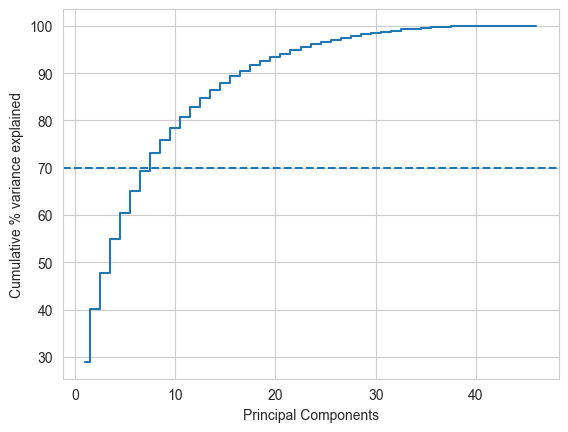

In [136]:
# 1️⃣ Fit PCA on the pre-processed data
X_prepared = preprocessor.fit_transform(df_km)
pca = PCA().fit(X_prepared)

# 2️⃣ Plot cumulative explained variance
plt.step(range(1, len(pca.explained_variance_ratio_)+1),
         np.cumsum(pca.explained_variance_ratio_)*100, where='mid')
plt.xlabel("Principal Components")
plt.ylabel("Cumulative % variance explained")
plt.axhline(70, ls='--')
plt.show()


In [138]:
loadings = pd.DataFrame(
    pca.components_.T,
    index = preprocessor.get_feature_names_out(),
    columns = [f'PC{i+1}' for i in range(pca.n_components_)]
)

# Show top ±5 strongest contributors for the first few PCs
for pc in loadings.columns[:6]:
    print(f"\n=== {pc} ===")
    print(loadings[pc].abs().sort_values(ascending=False).head(10))



=== PC1 ===
num__SHOP_ONLINE    0.289436
num__DINK           0.285729
num__OWN_HOUSE      0.280361
num__SOCCL_A        0.278148
num__EDU_LOW        0.269746
num__AVG_HOUSE      0.267791
num__SOCCL_C        0.265660
num__SAVINGS        0.261945
num__EDU_HIGH       0.257940
num__SOCCL_D        0.255850
Name: PC1, dtype: float64

=== PC2 ===
num__worth_car            0.521524
num__weight_car           0.514237
num__power_car            0.498578
num__premium_total        0.274139
num__premium_discount     0.189466
num__car_age              0.166355
cat__fuel_car_GASOLINE    0.122824
cat__fuel_car_DIESEL      0.117521
num__LOAN                 0.114529
num__CIT_HOUSEHOLD        0.077630
Name: PC2, dtype: float64

=== PC3 ===
num__EDU_MID        0.486934
num__LOAN           0.362312
num__SOCCL_B2       0.323105
num__SOCCL_B1       0.277282
num__SOCCL_A        0.237661
num__SOCCL_D        0.224766
num__age            0.223132
num__SHOP_ONLINE    0.201844
num__EDU_LOW        0.188869
num__URB

In [116]:
def top_n_loadings(pca, preprocessor, n=5):
    # 1) assemble the full loading matrix
    loadings = pd.DataFrame(
        pca.components_.T,
        index=preprocessor.get_feature_names_out(),
        columns=[f'PC{i+1}' for i in range(pca.n_components_)]
    )

    # 2) for each PC, grab the top-n features by absolute loading
    top_feats = {}
    for pc in loadings.columns:
        top_feats[pc] = (
            loadings[pc]
            .abs()
            .nlargest(n)
            .index
            .tolist()
        )

    # 3) build a DataFrame (rows = rank, cols = PCs)
    return pd.DataFrame(top_feats)

# usage:
top5 = top_n_loadings(pca, preprocessor, n=10)
print(top5)

                PC1                     PC2               PC3  \
0  num__SHOP_ONLINE          num__worth_car      num__EDU_MID   
1         num__DINK         num__weight_car         num__LOAN   
2    num__OWN_HOUSE          num__power_car     num__SOCCL_B2   
3      num__SOCCL_A      num__premium_total     num__SOCCL_B1   
4      num__EDU_LOW   num__premium_discount      num__SOCCL_A   
5    num__AVG_HOUSE            num__car_age      num__SOCCL_D   
6      num__SOCCL_C  cat__fuel_car_GASOLINE          num__age   
7      num__SAVINGS    cat__fuel_car_DIESEL  num__SHOP_ONLINE   
8     num__EDU_HIGH               num__LOAN      num__EDU_LOW   
9      num__SOCCL_D      num__CIT_HOUSEHOLD          num__URB   

                  PC4                    PC5  \
0            num__URB     num__CIT_HOUSEHOLD   
1       num__EDU_HIGH           num__EDU_MID   
2  num__STAGE_OF_LIFE  num__premium_discount   
3            num__CAR              num__LOAN   
4  num__CIT_HOUSEHOLD               num__age

In [139]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=preprocessor.get_feature_names_out(),
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

loadings = loadings.reset_index().rename(columns={'index':'feature'})

In [141]:
loadings.head(10)

,feature,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46
0,num__premium_total,-0.038892,0.274139,0.176654,-0.053004,0.271021,0.475774,0.116686,-0.103801,0.086401,...,-0.008414,-0.015246,0.007335,-0.003836,-0.011140,-0.001716,0.009288,0.000000e+00,0.000000e+00,0.000000e+00
1,num__premium_discount,-0.042210,0.189466,0.105573,-0.079372,0.333538,0.482502,0.186723,0.155674,0.278290,...,0.008978,0.010344,-0.009016,0.002657,-0.007704,0.003029,-0.012179,4.192194e-17,-3.996849e-15,9.433064e-17
2,num__worth_car,0.035155,0.521524,-0.044846,0.002588,-0.165730,-0.132385,0.048551,-0.042887,-0.020126,...,0.025568,-0.009780,0.097377,0.007542,-0.022647,-0.004151,0.010485,-5.064368e-16,-4.146634e-16,-4.556730e-17
3,num__weight_car,0.029410,0.514237,-0.042530,0.001483,-0.176416,-0.112373,0.052597,-0.071185,-0.029648,...,-0.022964,0.011325,-0.013135,0.003238,-0.041629,0.023709,0.017059,1.795944e-15,7.635499e-16,2.689520e-16
4,num__mileage_car,0.027466,0.066210,-0.051798,0.048628,0.083704,-0.227918,0.165204,0.840698,-0.114469,...,-0.020482,-0.007572,0.001977,0.000231,0.003297,-0.005728,-0.000907,-1.905748e-16,-3.639912e-16,-1.115051e-16
5,num__power_car,0.042644,0.498578,-0.049797,0.000162,-0.207964,-0.130501,0.090958,-0.096089,0.010121,...,-0.004047,0.006859,-0.073112,-0.008159,0.057610,-0.012254,-0.021581,-8.288055e-16,8.393235e-16,-1.614727e-16
6,num__URB,0.099716,-0.059673,-0.187521,0.349826,-0.215497,0.087473,0.372990,0.104856,0.243281,...,-0.025660,-0.003083,0.017101,-0.003400,-0.009051,-0.005718,0.002814,-2.089414e-16,-8.693699e-16,-5.161923e-17
7,num__INCOME_final,-0.192665,0.005985,-0.063670,0.187778,-0.047777,0.162335,-0.027405,-0.019590,-0.475407,...,-0.013268,-0.004825,-0.002478,-0.004753,-0.001853,-0.008997,-0.001366,1.541675e-16,-6.816173e-16,-1.439589e-17
8,num__SOCCL_A,0.278148,-0.020430,-0.237661,-0.260738,0.106220,-0.019636,0.006403,-0.007385,0.019785,...,-0.018058,0.000350,0.054259,-0.018191,0.020539,-0.018183,-0.007052,5.800037e-16,3.573516e-15,-3.422075e-16
9,num__SOCCL_B1,0.221922,-0.017663,0.277282,0.179947,-0.190701,0.145557,-0.012279,-0.057396,-0.197758,...,-0.020334,-0.006343,0.014862,0.009031,0.010161,0.000137,-0.003683,-6.830006e-16,4.852905e-16,-2.300791e-16


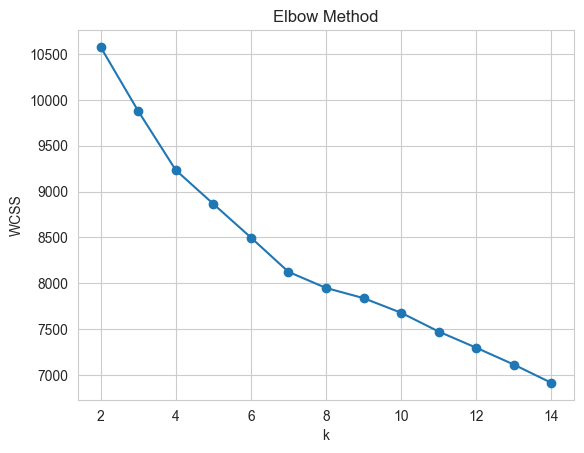

In [142]:
wcss = []                         # within-cluster sum of squares
K = range(2, 15)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_prepared)
    wcss.append(km.inertia_)

plt.plot(K, wcss, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()


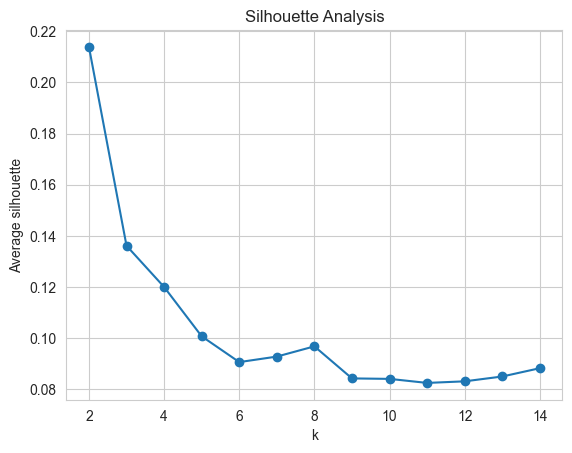

In [143]:
sil = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_prepared)
    sil.append(silhouette_score(X_prepared, labels))

plt.plot(K, sil, marker='o')
plt.xlabel('k')
plt.ylabel('Average silhouette')
plt.title('Silhouette Analysis')
plt.show()


In [145]:
k_final = 8
n_pcs   = 8            # or whatever your elbow-cum-variance plot suggested

pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca',  PCA(n_components=n_pcs, random_state=42)),   # comment out if you skip PCA
    ('km',   KMeans(n_clusters=k_final, random_state=42))
])

df_km['cluster'] = pipeline.fit_predict(df_km)

In [146]:
sizes = df_km['cluster'].value_counts().sort_index()
print(sizes)

cluster
0    52
1    81
2    39
3    79
4    59
5    46
6    62
7    63
Name: count, dtype: int64


In [147]:
centroids_pca = pipeline.named_steps['km'].cluster_centers_
centroids_pca = pd.DataFrame(centroids_pca,
                             columns=[f'PC{i+1}' for i in range(centroids_pca.shape[1])])

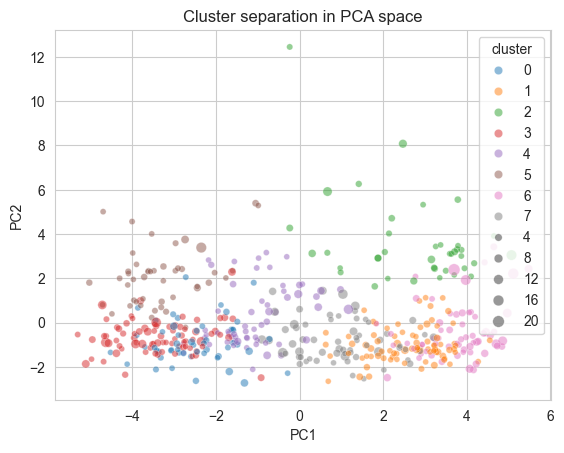

In [153]:
pcs = pipeline.named_steps['pca'].transform(preprocessor.transform(df_km))
sns.scatterplot(x=pcs[:,0], 
                y=pcs[:,1], 
                hue=df_km['cluster'], 
                size=pcs[:,2]**2,
                palette='tab10', 
                alpha=.5)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Cluster separation in PCA space')
plt.show()

In [154]:
df_km

,premium_total,premium_discount,worth_car,weight_car,mileage_car,power_car,fuel_car,PROVINCE,URB,INCOME_final,...,STAGE_OF_LIFE,CIT_HOUSEHOLD,LOAN,SAVINGS,SHOP_ONLINE,CAR,age,coverage_type,car_age,cluster
952,757.47,7.49,10630.000000,839.000000,15.000000,55.000000,GASOLINE,North Brabant,7.0,2.0,...,4.0,5.0,1.0,4.0,6.0,5.0,53.0,2. Liability + limited casco,8.0,1
1109,961.36,0.00,17134.000000,954.000000,15.000000,44.000000,GASOLINE,North Brabant,2.0,2.0,...,9.0,5.0,2.0,6.0,6.0,5.0,63.0,2. Liability + limited casco,10.0,6
1120,1923.90,45.92,26990.000000,1225.000000,15.000000,86.000000,GASOLINE,South Holland,4.0,2.0,...,9.0,3.0,1.0,5.0,4.0,5.0,72.0,3. Liability + full casco,8.0,1
1220,1121.39,7.49,36486.000000,1405.000000,20.000000,92.000000,DIESEL,Utrecht,2.0,2.0,...,6.0,5.0,4.0,5.0,6.0,5.0,66.0,1. Only liability insurance,16.0,2
1237,817.26,0.00,17695.000000,1076.000000,15.000000,55.000000,GASOLINE,Groningen,2.0,4.0,...,6.0,4.0,3.0,2.0,2.0,2.0,41.0,1. Only liability insurance,18.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9194,0.00,0.00,11864.000000,830.800000,13.000000,53.800000,GASOLINE,South Holland,1.0,4.0,...,4.0,5.0,6.0,6.0,6.0,5.0,54.0,1. Only liability insurance,11.0,7
9195,0.00,0.00,16098.809524,1014.904762,14.761905,58.333333,GASOLINE,South Holland,1.0,4.0,...,1.0,4.0,4.0,2.0,1.0,1.0,61.0,3. Liability + full casco,7.0,3
9199,0.00,0.00,16098.809524,1014.904762,14.761905,58.333333,GASOLINE,Utrecht,4.0,2.0,...,6.0,4.0,4.0,4.0,4.0,4.0,24.0,1. Only liability insurance,6.0,7
9205,0.00,0.00,15378.481481,955.962963,13.518519,62.370370,GASOLINE,Overijssel,4.0,2.0,...,6.0,6.0,2.0,6.0,6.0,5.0,21.0,1. Only liability insurance,17.0,1


In [155]:
df_km.to_csv("customers_with_clusters.csv", index=False)

In [156]:
# 1. grab fitted steps
scaler = pipeline.named_steps['prep'] \
                .named_transformers_['num'] \
                .named_steps['scaler']
ohe    = pipeline.named_steps['prep'] \
                .named_transformers_['cat'] \
                .named_steps['ohe']
pca    = pipeline.named_steps['pca']
km     = pipeline.named_steps['km']

# 2. get cluster centers in PCA space
centroids_pca = km.cluster_centers_

# 3. inverse‐PCA → back to scaled & one-hot space
centroids_preproc = pca.inverse_transform(centroids_pca)

# 4. split numeric vs encoded parts
n_num = len(num_features)
num_scaled = centroids_preproc[:, :n_num]
cat_encoded = centroids_preproc[:, n_num:]

# 5. inverse‐scale numerics → original units
num_orig = scaler.inverse_transform(num_scaled)

# 6. inverse‐encode categoricals → original PROVINCE values
#    Note: result is shape (n_clusters, 1)
province_orig = ohe.inverse_transform(cat_encoded).ravel()

# 7. assemble into a DataFrame
centroids_df = pd.DataFrame(num_orig, columns=num_features)
centroids_df['PROVINCE'] = province_orig

# 8. round for readability
centroids_df[num_features] = centroids_df[num_features].round(2)

print("Cluster centers back in original feature space:")
print(centroids_df)


ValueError: Length of values (24) does not match length of index (8)

In [95]:
centroids_df

,premium_total,premium_discount,worth_car,weight_car,mileage_car,power_car,URB,INCOME_final,SOCCL_A,SOCCL_B1,...,OWN_HOUSE,AVG_HOUSE,STAGE_OF_LIFE,CIT_HOUSEHOLD,LOAN,SAVINGS,SHOP_ONLINE,CAR,age,car_age
0,568.104646,22.483331,16497.216684,987.706390,14.063550,60.060866,3.148298,4.153783,1.094459,1.170579,...,1.409891,3.663325,2.793922,3.300356,2.750211,2.700904,1.897648,2.046729,35.571677,15.350021
1,1161.521672,29.940539,46530.855629,1477.795166,14.915939,120.394793,3.772194,2.615133,2.652801,3.009701,...,3.605412,7.773116,5.108932,4.339648,3.501770,5.217009,5.608006,4.343298,37.494417,9.928958
2,878.995316,29.453462,24700.318682,1111.325459,15.089249,73.149320,2.746810,3.866837,1.025023,1.499612,...,1.778914,4.768303,4.284723,4.388053,4.021970,2.775428,2.803869,2.987378,31.208449,11.034140
3,414.341118,18.159831,18155.700837,999.962944,14.647243,63.532499,3.291938,1.756055,4.350698,2.220175,...,3.991765,9.594784,5.806765,4.478902,3.005206,5.606324,5.766275,4.435285,40.631151,10.593367
4,620.708575,17.928999,16970.318005,987.744942,14.374493,60.977225,2.377380,3.038677,1.390947,2.339085,...,1.953605,4.695652,2.309637,2.779302,3.630020,4.597463,4.229589,2.258862,31.748150,13.964470
5,483.789261,11.505701,15666.653044,964.529787,14.721851,58.256079,4.257273,3.058096,2.224889,3.316588,...,3.864900,7.503087,6.208209,4.413683,3.043436,4.954925,5.256390,4.633871,39.916851,11.399283


In [98]:
import pandas as pd

# 1. grab fitted steps
scaler = pipeline.named_steps['prep'] \
                .named_transformers_['num'] \
                .named_steps['scaler']
ohe    = pipeline.named_steps['prep'] \
                .named_transformers_['cat'] \
                .named_steps['ohe']
pca    = pipeline.named_steps['pca']
km     = pipeline.named_steps['km']

# 2. get cluster centers in PCA space
centroids_pca = km.cluster_centers_

# 3. inverse‐PCA → back to scaled & one-hot space
centroids_preproc = pca.inverse_transform(centroids_pca)

# 4. split numeric vs encoded parts
n_num = len(num_features)
num_scaled   = centroids_preproc[:, :n_num]
cat_encoded  = centroids_preproc[:, n_num:]   # shape: (n_clusters, sum_ohe_dims)

# 5. inverse‐scale numerics → original units
num_orig = scaler.inverse_transform(num_scaled)

# 6. inverse‐encode categoricals → back to each original categorical column
#    This returns shape (n_clusters, n_cat_features)
cat_orig = ohe.inverse_transform(cat_encoded)

# 7. assemble into a DataFrame
centroids_df = pd.DataFrame(num_orig, columns=num_features)
centroids_cats = pd.DataFrame(cat_orig, columns=cat_features)
centroids_df = pd.concat([centroids_df, centroids_cats], axis=1)

# 8. round numeric cols for readability
centroids_df[num_features] = centroids_df[num_features].round(2)

print("Cluster centers back in original feature space:")
print(centroids_df)


ValueError: operands could not be broadcast together with shapes (6,4) (27,) (6,4) 